In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.autograd import Variable
from IPython.display import HTML

torch.seed () 

1509899750364109961

In [ ]:
dataroot = "data" # dir with images

num_workers = 2

batch_size = 128

image_size = 32

num_channels = 3 # number of channels of the input image

latent_size = 100 # size of the latent vector

gen_dim  = 64 # size of the feature maps in the generator 

dis_dim = 64 # size of the feature maps in the discriminator

num_epochs = 5 # number of epochs to run for

learning_rate = 0.0002 # lr

beta1 = 0.5

In [ ]:
dataset = dset.CIFAR10(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]), download=True)

Extracting data/cifar-10-python.tar.gz to data


In [ ]:
# The number of classes in the CIFAR 10 dataset (10)
num_classes = len (dataset.classes)

# Images are of size 3 * 32 * 32 
image_dim = (3, image_size, image_size)

In [ ]:
# Load in the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)


In [ ]:
# Use gpu if present
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


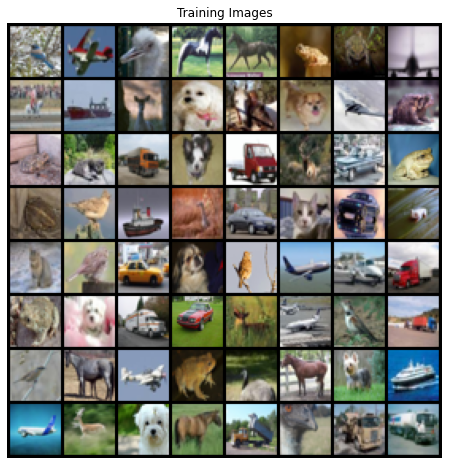

In [ ]:
#Ensure that data was loaded correctly by printing out a few pictures

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        
        def block(in_feat, out_feat, normalize=True):
          """
          Generate a linear layer with batch normalization and 
          a leaky ReLU
          """ 
          layers = [nn.Linear(in_feat, out_feat)]
          if normalize:
              layers.append(nn.BatchNorm1d(out_feat, 0.8)) 
          layers.append(nn.LeakyReLU(0.2, inplace=True))
          return layers

        # Information about the class is appended to 
        # the latent vector to condition the input
        self.model = nn.Sequential(
            *block(latent_size + num_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            *block(1024, 3072),
            nn.Linear(3072, int(np.prod(image_dim))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Input is a concatenation of the latent vector and 
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *image_dim)
        return img

In [ ]:
# Create the generator
netG = Generator().to(device)

# Print the model
print(netG)

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=3072, bias=True)
    (12): BatchNorm1d(3072, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=Tru

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        def block(in_features, out_features, dropout=True, relu=True):
          layers = [nn.Linear(in_features, out_features)]
          if dropout:
            layers.append(nn.Dropout(0.5))
          if relu:
            layers.append(nn.LeakyReLU(0.2, inplace=True))

          return layers
            
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(image_dim)), 1024),
            nn.LeakyReLU(0.2, inplace=True),
            *block(1024, 512, dropout=True, relu=True),
            *block(512, 512, dropout=True, relu=True),
            *block(512, 512, dropout=True, relu=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Print the model
print(netD)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=3082, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [ ]:
# Initialize MSELoss function
criterion = torch.nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [18]:
FloatTensor = torch.cuda.FloatTensor if device == 'cuda' else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if device == 'cuda' else torch.LongTensor

# ----------
#  Training
# ----------

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = FloatTensor(batch_size, 1).fill_(1.0)
        fake = FloatTensor(batch_size, 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(FloatTensor)
        labels = labels.type(LongTensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizerG.zero_grad()

        # Sample noise and labels as generator input
        z = FloatTensor(np.random.normal(0, 1, (batch_size, latent_size)))
        gen_labels = LongTensor(np.random.randint(0, num_classes, batch_size))

        # Generate a batch of images
        gen_imgs = netG(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = netD (gen_imgs, gen_labels)
        g_loss = criterion (validity, valid)

        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizerD.zero_grad()

        # Loss for real images
        validity_real = netD(real_imgs, labels)
        d_real_loss = criterion(validity_real, valid)

        # Loss for fake images
        validity_fake = netD(gen_imgs.detach(), gen_labels)
        d_fake_loss = criterion(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizerD.step()

        if i % 50 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch+1, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
          )


        # Save the losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

[Epoch 1/50] [Batch 0/391] [D loss: 0.190652] [G loss: 0.358147]
[Epoch 1/50] [Batch 50/391] [D loss: 0.191734] [G loss: 0.482318]
[Epoch 1/50] [Batch 100/391] [D loss: 0.221525] [G loss: 0.409375]
[Epoch 1/50] [Batch 150/391] [D loss: 0.202373] [G loss: 0.355553]
[Epoch 1/50] [Batch 200/391] [D loss: 0.194933] [G loss: 0.385256]
[Epoch 1/50] [Batch 250/391] [D loss: 0.191966] [G loss: 0.395224]
[Epoch 1/50] [Batch 300/391] [D loss: 0.196110] [G loss: 0.437743]
[Epoch 1/50] [Batch 350/391] [D loss: 0.224127] [G loss: 0.356439]
[Epoch 2/50] [Batch 0/391] [D loss: 0.222065] [G loss: 0.356320]
[Epoch 2/50] [Batch 50/391] [D loss: 0.192727] [G loss: 0.450613]
[Epoch 2/50] [Batch 100/391] [D loss: 0.200294] [G loss: 0.346695]
[Epoch 2/50] [Batch 150/391] [D loss: 0.190122] [G loss: 0.469552]
[Epoch 2/50] [Batch 200/391] [D loss: 0.190920] [G loss: 0.387815]
[Epoch 2/50] [Batch 250/391] [D loss: 0.204142] [G loss: 0.447200]
[Epoch 2/50] [Batch 300/391] [D loss: 0.197093] [G loss: 0.412850]
[

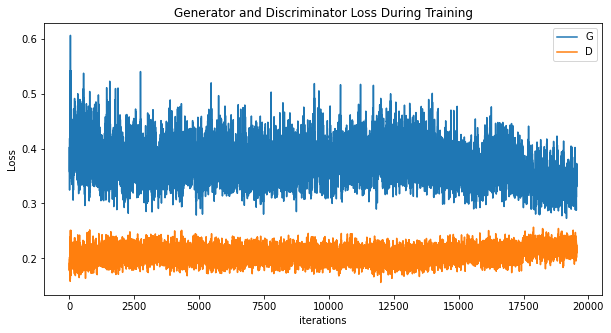

In [19]:
# Graph the result

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
# Save the models 

torch.save (netG.state_dict(), './data/generator.pth')
torch.save (netD.state_dict(), './data/discriminator.pth')

In [38]:
def sample_image(n_row):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_size))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = netG(z, labels)
    return gen_imgs

In [39]:
images = sample_image (num_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

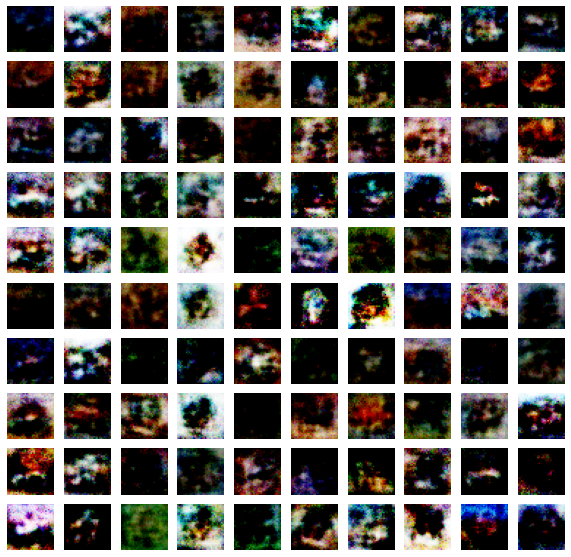

(100, 3, 32, 32)


In [87]:
c_img = images.cpu()
c_img = c_img.detach().numpy()

fig,axes = plt.subplots(nrows = 10, ncols = 10, figsize=(10,10))

for ax in axes.flatten():
    ax.axis('off')

for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(c_img[i], (1, 2, 0)))
plt.show()

print(c_img.shape)

In [ ]:
 """ 
 Sources 
 -------

 (1) https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py

 """